## Librerias y primer vistazo a los datos

In [8]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import spacy

In [9]:
data = pd.read_csv('dataset\df_200k.csv')
data.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\luisb\AppData\Local\Temp\ipykernel_26100\999136571.py:1: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('dataset\df_200k.csv')


,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   id      200000 non-null  int64 
 2   date    200000 non-null  object
 3   query   200000 non-null  object
 4   user    200000 non-null  object
 5   text    200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.2+ MB


In [11]:
data.describe()

,target,id
count,200000.0,2.000000e+05
mean,0.0,1.772565e+09
std,0.0,1.520760e+08
min,0.0,1.467810e+09
25%,0.0,1.678338e+09
50%,0.0,1.793821e+09
75%,0.0,1.883596e+09
max,0.0,1.971571e+09


In [12]:
data.isnull().sum()

target    0
id        0
date      0
query     0
user      0
text      0
dtype: int64

In [13]:
data_clean = data[["text"]]
data_clean.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


## 1. Análisis exploratorio y preprocesamiento

### Análisis estadístico del corpus 

In [14]:
# Tokenización y limpieza básica (quita URLs, menciones, puntuación básica)
def clean_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' ', text)        # URLs
    text = re.sub(r'@\w+', ' ', text)           # menciones
    text = re.sub(r'#', ' ', text)              # quitar # pero mantener la palabra

    # conservar letras y números (incluye acentos)
    # quitar acentos 
    text = re.sub(r'[^0-9a-záéíóúüñ\s]', ' ', text, flags=re.IGNORECASE)
    tokens = re.findall(r'\w+', text, flags=re.UNICODE)
    return tokens

In [15]:
# Construir distribución de frecuencias de tokens
freq = Counter()
total_tokens = 0
for doc in data_clean['text'].astype(str):
    toks = clean_and_tokenize(doc)
    freq.update(toks)
    total_tokens += len(toks)

vocab = len(freq)
print(f"Tokens totales: {total_tokens:,}")
print(f"Vocabulario (tipos): {vocab:,}")


Tokens totales: 2,736,879
Vocabulario (tipos): 75,418


In [16]:
# DataFrame-like structures para análisis
words, counts = zip(*freq.most_common())
ranks = np.arange(1, len(counts) + 1)
counts_arr = np.array(counts)


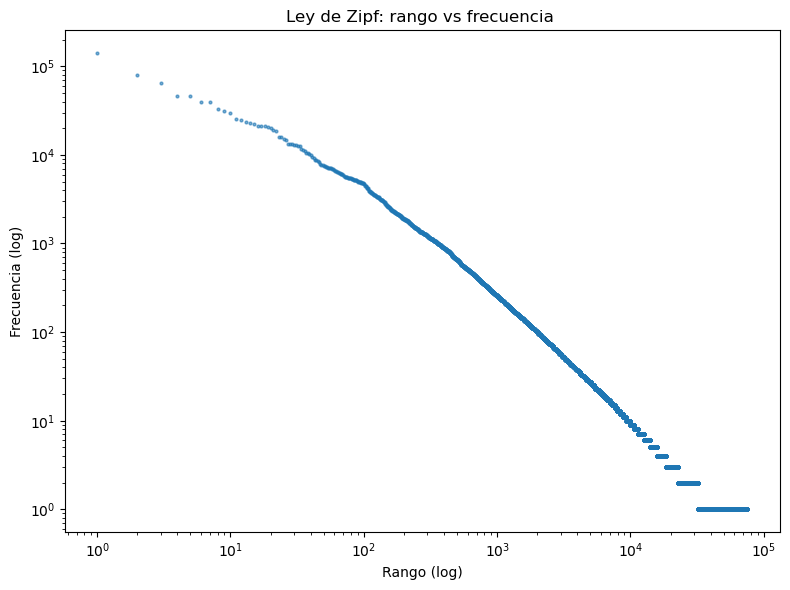

In [17]:
# Ley de Zipf: gráfico rango vs frecuencia (log-log) y ajuste lineal en log-log
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Ley de Zipf: rango vs frecuencia ')
plt.tight_layout()
plt.show()


Ajuste log-log (primeros 2000): slope = -1.1871, intercept = 13.7391
Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)


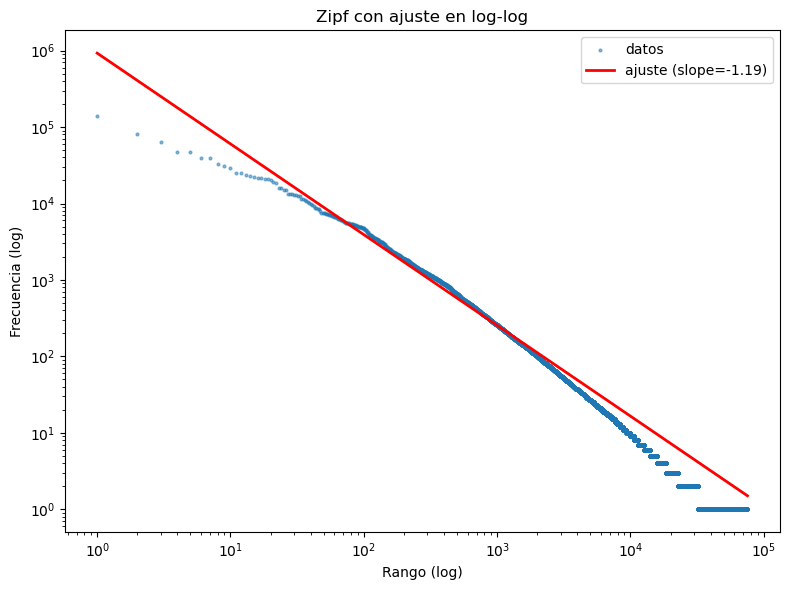

In [18]:
# Ajuste lineal en log-log para los primeros K ranks (p. ej. 1..2000)
K = min(2000, len(counts_arr))
log_r = np.log(ranks[:K])
log_f = np.log(counts_arr[:K])
slope, intercept = np.polyfit(log_r, log_f, 1)
print(f"Ajuste log-log (primeros {K}): slope = {slope:.4f}, intercept = {intercept:.4f}")
print("Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)")

# Dibujar la línea ajustada sobre el scatter 
pred_logf = intercept + slope * np.log(ranks[:])
pred_f = np.exp(pred_logf)
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.5, label='datos')
plt.plot(ranks[:], pred_f, color='red', lw=2, label=f'ajuste (slope={slope:.2f})')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Zipf con ajuste en log-log')
plt.legend()
plt.tight_layout()
plt.show()

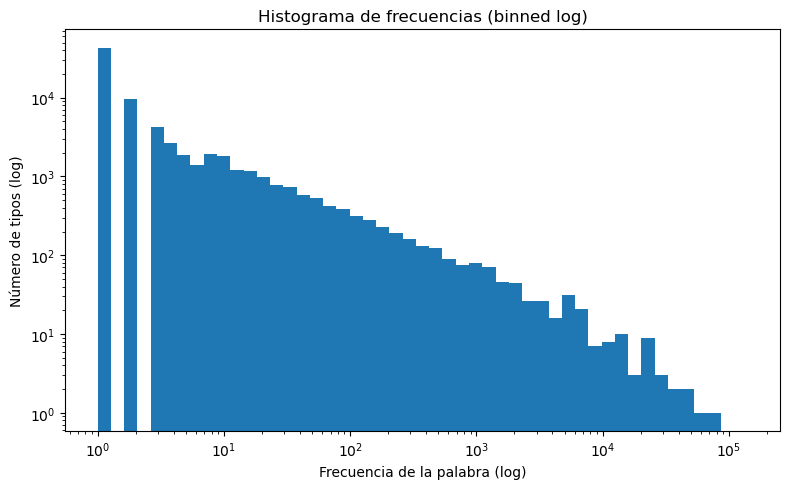

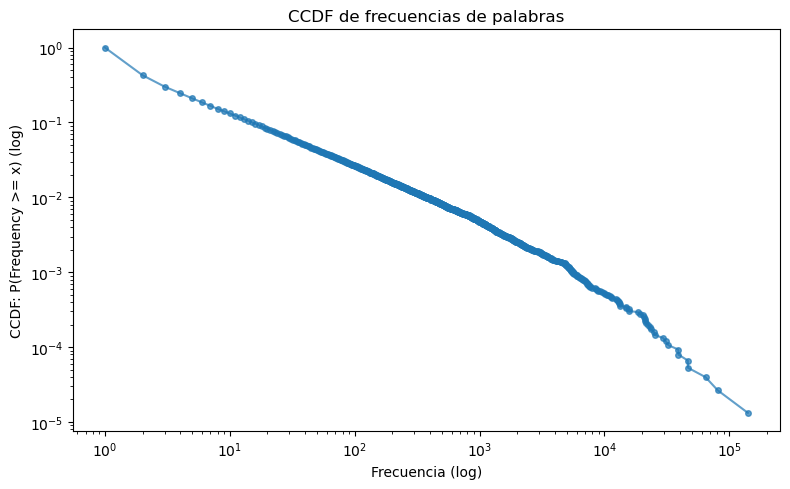

In [19]:
# Distribución de frecuencias: histograma (log-binned) y CCDF
# Histograma con ejes log
plt.figure(figsize=(8,5))
plt.hist(counts_arr, bins=np.logspace(np.log10(1), np.log10(counts_arr.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frecuencia de la palabra (log)')
plt.ylabel('Número de tipos (log)')
plt.title('Histograma de frecuencias (binned log)')
plt.tight_layout()
plt.show()

# CCDF: proporción de tipos con frecuencia >= x
sorted_counts = np.sort(counts_arr)
unique_vals, counts_of_vals = np.unique(sorted_counts, return_counts=True)
ccdf_vals = np.cumsum(counts_of_vals[::-1])[::-1] / vocab  # proporción de tipos >= val
plt.figure(figsize=(8,5))
plt.loglog(unique_vals, ccdf_vals, marker='o', ms=4, alpha=0.7)
plt.xlabel('Frecuencia (log)')
plt.ylabel('CCDF: P(Frequency >= x) (log)')
plt.title('CCDF de frecuencias de palabras')
plt.tight_layout()
plt.show()

In [20]:
# Resumen: top-20 palabras
top_n = 20
print(f"\nTop {top_n} palabras:")
for i, (w, c) in enumerate(freq.most_common(top_n), 1):
    print(f"{i:2d}. {w:15s} {c:,} ({c/total_tokens:.4%} del total de tokens)")


Top 20 palabras:
 1. i               140,663 (5.1395% del total de tokens)
 2. to              80,731 (2.9497% del total de tokens)
 3. the             64,433 (2.3543% del total de tokens)
 4. a               46,639 (1.7041% del total de tokens)
 5. my              46,498 (1.6989% del total de tokens)
 6. it              39,108 (1.4289% del total de tokens)
 7. and             39,011 (1.4254% del total de tokens)
 8. is              32,534 (1.1887% del total de tokens)
 9. t               30,928 (1.1300% del total de tokens)
10. in              29,459 (1.0764% del total de tokens)
11. you             25,162 (0.9194% del total de tokens)
12. for             24,921 (0.9106% del total de tokens)
13. of              23,610 (0.8627% del total de tokens)
14. s               23,077 (0.8432% del total de tokens)
15. me              22,412 (0.8189% del total de tokens)
16. on              21,345 (0.7799% del total de tokens)
17. so              21,295 (0.7781% del total de tokens)
18. but     

### Pipeline de limpieza específico para reseñas

In [ ]:
def comparar_lemmatizadores_en_columna(df, col_tokens='filtered_tokens', idioma='en', prefer_spacy=True):
    """Lemmatiza listas de tokens en la columna `col_tokens` de df.
    Crea columnas: filtered_lemmas_spacy, filtered_lemmas_nltk y filtered_lemmas (preferida)."""

    # NLTK WordNet Lemmatizer (principalmente para inglés)
    lemmatizer_nltk = WordNetLemmatizer()

    # Intentar cargar modelo spaCy apropiado (sm para ser más ligero)
    spacy_model = 'en_core_web_sm' if idioma == 'en' else 'es_core_news_sm'
    try:
        nlp = spacy.load(spacy_model, disable=['parser', 'ner', 'textcat'])
        has_spacy = True
        print(f"spaCy cargado: {spacy_model}")
    except Exception as e:
        nlp = None
        has_spacy = False
        print(f"No se pudo cargar spaCy ({spacy_model}), fallback a NLTK. Error: {e}")

    tokens_lists = df[col_tokens].astype(object).tolist()

    # Lemmatización con NLTK (simple, token por token)
    lemmas_nltk = [
        [lemmatizer_nltk.lemmatize(t) for t in toks]
        for toks in tokens_lists
    ]

    # Lemmatización con spaCy (si está disponible). Usamos nlp.pipe para eficiencia.
    if has_spacy:
        texts = [" ".join(toks) if len(toks) else "" for toks in tokens_lists]
        lemmas_spacy = []
        for doc in nlp.pipe(texts, batch_size=2000):
            # si texto vacío, doc puede estar vacío
            if len(doc) == 0:
                lemmas_spacy.append([])
            else:
                # tomar lemma de cada token segmentado por spaCy
                lemmas_spacy.append([t.lemma_ for t in doc])
    else:
        lemmas_spacy = [list(ln) for ln in lemmas_nltk]  # copia de fallback

    # Añadir columnas al DataFrame
    df['filtered_lemmas_nltk'] = lemmas_nltk
    df['filtered_lemmas_spacy'] = lemmas_spacy

    # Columna final preferida
    if prefer_spacy and has_spacy:
        df['filtered_lemmas'] = df['filtered_lemmas_spacy']
    else:
        df['filtered_lemmas'] = df['filtered_lemmas_nltk']

    # Mostrar ejemplos
    print("\nEjemplos (primeras 5 filas):")
    display(df[[col_tokens, 'filtered_lemmas_nltk', 'filtered_lemmas_spacy', 'filtered_lemmas']].head())

    return df

# Aplicar la función al dataframe data_clean (asumiendo que existe la columna 'filtered_tokens')
data_clean = comparar_lemmatizadores_en_columna(data_clean, col_tokens='filtered_tokens', idioma='en', prefer_spacy=True)

No se pudo cargar spaCy (en_core_web_sm), fallback a NLTK. Error: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

Ejemplos (primeras 5 filas):


C:\Users\javie\AppData\Local\Temp\ipykernel_26872\1835420511.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filtered_lemmas_nltk'] = lemmas_nltk
C:\Users\javie\AppData\Local\Temp\ipykernel_26872\1835420511.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filtered_lemmas_spacy'] = lemmas_spacy
C:\Users\javie\AppData\Local\Temp\ipykernel_26872\1835420511.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,filtered_tokens,filtered_lemmas_nltk,filtered_lemmas_spacy,filtered_lemmas
0,"[awww, bummer, shoulda, got, david, carr, thir...","[awww, bummer, shoulda, got, david, carr, thir...","[awww, bummer, shoulda, got, david, carr, thir...","[awww, bummer, shoulda, got, david, carr, thir..."
1,"[upset, update, facebook, texting, might, cry,...","[upset, update, facebook, texting, might, cry,...","[upset, update, facebook, texting, might, cry,...","[upset, update, facebook, texting, might, cry,..."
2,"[dived, many, times, ball, managed, save, 50, ...","[dived, many, time, ball, managed, save, 50, r...","[dived, many, time, ball, managed, save, 50, r...","[dived, many, time, ball, managed, save, 50, r..."
3,"[whole, body, feels, itchy, like, fire]","[whole, body, feel, itchy, like, fire]","[whole, body, feel, itchy, like, fire]","[whole, body, feel, itchy, like, fire]"
4,"[behaving, mad, see]","[behaving, mad, see]","[behaving, mad, see]","[behaving, mad, see]"
